In [1]:
!pip install -q google-cloud-storage
!pip install -q google-cloud

In [4]:
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='/workspaces/MLOps/mlops-437407-225d42b6661e.json'

In [2]:
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')
import mlflow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as RMSE 
import xgboost as xgb

In [3]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval 
from hyperopt.early_stop import no_progress_loss

In [5]:
mlflow.set_tracking_uri("http://34.139.217.57:5000/")
mlflow.set_experiment("NYC-Taxi-Regressor")

<Experiment: artifact_location='gs://mlflow-bucket-susu/1', creation_time=1728115156501, experiment_id='1', last_update_time=1728115156501, lifecycle_stage='active', name='NYC-Taxi-Regressor', tags={}>

In [6]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [7]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [8]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [9]:
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

In [10]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04


In [11]:
df.duration = df.duration.apply(lambda ld : ld.total_seconds()/60)

In [12]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


In [13]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [14]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

#### **98% 56.000000 : Most of the trip (98%) duration is within an Hour**
#### we should focus in that range only

In [15]:
df = df[(df.duration >= 1.0) & (df.duration <= 60.0)]

In [16]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [17]:
df.duration.mean()

16.852578430841948

<Axes: xlabel='duration', ylabel='Density'>

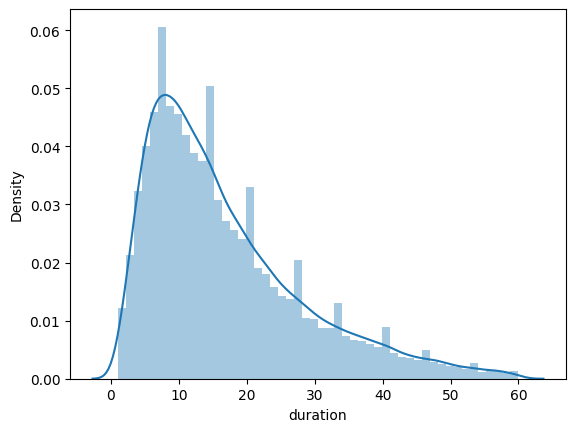

In [18]:
sns.distplot(df.duration)

In [19]:
df.isna().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag       35733
RatecodeID               35733
PULocationID                 0
DOLocationID                 0
passenger_count          35733
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                73908
improvement_surcharge        0
total_amount                 0
payment_type             35733
trip_type                35733
congestion_surcharge     35733
duration                     0
dtype: int64

In [20]:
df.drop(columns=['store_and_fwd_flag','RatecodeID','passenger_count','ehail_fee','payment_type','trip_type','congestion_surcharge'],inplace=True)

In [21]:
df.isna().sum()

VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
PULocationID             0
DOLocationID             0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
duration                 0
dtype: int64

In [22]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,43,151,1.01,5.5,0.5,0.5,0.00,0.0,0.3,6.80,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,166,239,2.53,10.0,0.5,0.5,2.81,0.0,0.3,16.86,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,41,42,1.12,6.0,0.5,0.5,1.00,0.0,0.3,8.30,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,168,75,1.99,8.0,0.5,0.5,0.00,0.0,0.3,9.30,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,75,75,0.45,3.5,0.5,0.5,0.96,0.0,0.3,5.76,2.316667


In [23]:
df = df.reset_index()

In [24]:
xvars = ['PULocationID','DOLocationID','trip_distance','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount']
yvars = ['duration']

In [25]:
Xtrain = df[xvars]
ytrain = df[yvars]

In [26]:
Xtrain

,PULocationID,DOLocationID,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,43,151,1.01,5.50,0.50,0.5,0.00,0.00,0.3,6.80
1,166,239,2.53,10.00,0.50,0.5,2.81,0.00,0.3,16.86
2,41,42,1.12,6.00,0.50,0.5,1.00,0.00,0.3,8.30
3,168,75,1.99,8.00,0.50,0.5,0.00,0.00,0.3,9.30
4,75,75,0.45,3.50,0.50,0.5,0.96,0.00,0.3,5.76
...,...,...,...,...,...,...,...,...,...,...
73903,81,90,17.63,56.23,2.75,0.0,0.00,6.12,0.3,65.40
73904,35,213,18.36,46.66,0.00,0.0,12.20,6.12,0.3,65.28
73905,74,69,2.50,18.95,2.75,0.0,0.00,0.00,0.3,22.00
73906,168,215,14.48,48.87,2.75,0.0,0.00,6.12,0.3,58.04


In [27]:
Xtrain.dtypes

PULocationID               int64
DOLocationID               int64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [28]:
Xtrain.head()

,PULocationID,DOLocationID,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,43,151,1.01,5.5,0.5,0.5,0.00,0.0,0.3,6.80
1,166,239,2.53,10.0,0.5,0.5,2.81,0.0,0.3,16.86
2,41,42,1.12,6.0,0.5,0.5,1.00,0.0,0.3,8.30
3,168,75,1.99,8.0,0.5,0.5,0.00,0.0,0.3,9.30
4,75,75,0.45,3.5,0.5,0.5,0.96,0.0,0.3,5.76


In [29]:
ytrain.head()

,duration
0,3.933333
1,8.750000
2,5.966667
3,7.083333
4,2.316667


In [30]:
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=42)

In [31]:
DTrain = xgb.DMatrix(X_train.values, y_train.values)
DVal = xgb.DMatrix(X_test.values, y_test.values)

## XGBoost

In [32]:
from hyperopt.pyll import scope

In [33]:
search_space = {
    "n_estimators": hp.choice("n_estimators", [10, 25, 50, 100, 200, 400]),
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [34]:
def objective(params):
    
    booster = xgb.train(
        params=params,
        dtrain=DTrain,
        num_boost_round=200,
        evals=[(DVal, 'validation')],
        early_stopping_rounds=50
    )
    
    y_pred = booster.predict(DVal)
    rmse = RMSE(y_test, y_pred)

    return {'loss': rmse, 'status': STATUS_OK}

### 1. max_evals=50 means that Hyperopt will test 50 different sets of hyperparameters (not all combinations).
### 2. Hyperopt uses the Tree of Parzen Estimators (TPE) algorithm (in your case, specified with algo=tpe.suggest) to suggest the next set of hyperparameters based on past results, rather than exhaustively trying all combinations.

In [35]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:8.84108                           
[1]	validation-rmse:7.22857                           
[2]	validation-rmse:6.32357                           
[3]	validation-rmse:5.83568                           
[4]	validation-rmse:5.59858                           
[5]	validation-rmse:5.47233                           
[6]	validation-rmse:5.42318                           
[7]	validation-rmse:5.39702                           
[8]	validation-rmse:5.38437                           
[9]	validation-rmse:5.37841                           
[10]	validation-rmse:5.37808                          
[11]	validation-rmse:5.37963                          
[12]	validation-rmse:5.38023                          
[13]	validation-rmse:5.38192                          
[14]	validation-rmse:5.38302                          
[15]	validation-rmse:5.38408                          
[16]	validation-rmse:5.38492                          
[17]	validation-rmse:5.38567                          
[18]	valid

In [36]:
best_params = best_result.copy()

best_params

{'learning_rate': 0.05736448914216723,
 'max_depth': 10.0,
 'min_child_weight': 9.761624550172625,
 'n_estimators': 4,
 'reg_alpha': 0.09772917591779555,
 'reg_lambda': 0.10548772866412592}

In [42]:
from google.cloud import storage 
client = storage.Client()

In [37]:
hyperparams = space_eval(search_space, best_result)

In [38]:
hyperparams

{'learning_rate': 0.05736448914216723,
 'max_depth': 10,
 'min_child_weight': 9.761624550172625,
 'n_estimators': 200,
 'objective': 'reg:linear',
 'reg_alpha': 0.09772917591779555,
 'reg_lambda': 0.10548772866412592,
 'seed': 42}

In [39]:
mlflow.xgboost.autolog()

booster = xgb.train(
            params=hyperparams,
            dtrain=DTrain,
            num_boost_round=500,
            evals=[(DVal, 'validation')],
            early_stopping_rounds=50
        )


2024/10/05 08:46:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '730586bbc7324f41bfd66cfd2b069517', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:10.97137
[1]	validation-rmse:10.46116
[2]	validation-rmse:9.98494
[3]	validation-rmse:9.54052
[4]	validation-rmse:9.12793
[5]	validation-rmse:8.74575
[6]	validation-rmse:8.39245
[7]	validation-rmse:8.06424
[8]	validation-rmse:7.75672
[9]	validation-rmse:7.47597
[10]	validation-rmse:7.21270
[11]	validation-rmse:6.97099
[12]	validation-rmse:6.74860
[13]	validation-rmse:6.54378
[14]	validation-rmse:6.35890
[15]	validation-rmse:6.18445
[16]	validation-rmse:6.02612
[17]	validation-rmse:5.88396
[18]	validation-rmse:5.75359
[19]	validation-rmse:5.63150
[20]	validation-rmse:5.52034
[21]	validation-rmse:5.41788
[22]	validation-rmse:5.32714
[23]	validation-rmse:5.24095
[24]	validation-rmse:5.16614
[25]	validation-rmse:5.09784
[26]	validation-rmse:5.03769
[27]	validation-rmse:4.98141
[28]	validation-rmse:4.92997
[29]	validation-rmse:4.88576
[30]	validation-rmse:4.84419
[31]	validation-rmse:4.80646
[32]	validation-rmse:4.77016
[33]	validation-rmse:4.73866
[34]	validation-rmse:4

2024/10/05 08:46:29 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/10/05 08:46:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/05 08:46:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run redolent-vole-506 at: http://34.139.217.57:5000/#/experiments/1/runs/730586bbc7324f41bfd66cfd2b069517.
2024/10/05 08:46:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://34.139.217.57:5000/#/experiments/1.


In [40]:
from sklearn.metrics import r2_score

In [45]:
from mlflow import MlflowClient
client = MlflowClient(tracking_uri="http://34.139.217.57:5000/")

In [46]:
all_experiments = client.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='gs://mlflow-bucket-susu/1', creation_time=1728115156501, experiment_id='1', last_update_time=1728115156501, lifecycle_stage='active', name='NYC-Taxi-Regressor', tags={}>]


In [49]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids= "1",
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=3,
    order_by=["metrics.rmse ASC"]
)

In [50]:
runs[0].data

<RunData: metrics={'best_iteration': 387.0,
 'stopped_iteration': 436.0,
 'validation-rmse': 4.254092496032542}, params={'custom_metric': 'None',
 'early_stopping_rounds': '50',
 'learning_rate': '0.05736448914216723',
 'max_depth': '10',
 'maximize': 'None',
 'min_child_weight': '9.761624550172625',
 'n_estimators': '200',
 'num_boost_round': '500',
 'objective': 'reg:linear',
 'reg_alpha': '0.09772917591779555',
 'reg_lambda': '0.10548772866412592',
 'seed': '42',
 'verbose_eval': 'True'}, tags={'mlflow.autologging': 'xgboost',
 'mlflow.log-model.history': '[{"run_id": "730586bbc7324f41bfd66cfd2b069517", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2024-10-05 08:46:29.611060", "model_uuid": '
                             '"d43ddc8ad8cc44a2a2daa7bb7411d426", "flavors": '
                             '{"python_function": {"loader_module": '
                             '"mlflow.xgboost", "python_version": "3.12.4", '
   

In [52]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['validation-rmse']}")

run id: 730586bbc7324f41bfd66cfd2b069517, rmse: 4.254092496032542
run id: b6ac39fd37a54b11a8394ea99caf5e14, rmse: 4.2814964610495325


In [53]:
RUN_ID = "730586bbc7324f41bfd66cfd2b069517"
MODEL_URI = f"runs:/{RUN_ID}/model"

In [54]:
assert client.search_model_versions(f"run_id = '{RUN_ID}'") == [], "Run has been registered!"

In [55]:
mlflow.register_model(model_uri = MODEL_URI, name="nyctaxi_tripduration_regressor")

Successfully registered model 'nyctaxi_tripduration_regressor'.
2024/10/05 09:07:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: nyctaxi_tripduration_regressor, version 1
Created version '1' of model 'nyctaxi_tripduration_regressor'.


<ModelVersion: aliases=[], creation_timestamp=1728119220068, current_stage='None', description='', last_updated_timestamp=1728119220068, name='nyctaxi_tripduration_regressor', run_id='730586bbc7324f41bfd66cfd2b069517', run_link='', source='gs://mlflow-bucket-susu/1/730586bbc7324f41bfd66cfd2b069517/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [56]:
RUN_ID = "b6ac39fd37a54b11a8394ea99caf5e14"
MODEL_URI = f"runs:/{RUN_ID}/model"
assert client.search_model_versions(f"run_id = '{RUN_ID}'") == [], "Run has been registered!"
mlflow.register_model(model_uri = MODEL_URI, name="nyctaxi_tripduration_regressor")

Registered model 'nyctaxi_tripduration_regressor' already exists. Creating a new version of this model...
2024/10/05 09:10:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: nyctaxi_tripduration_regressor, version 2
Created version '2' of model 'nyctaxi_tripduration_regressor'.


<ModelVersion: aliases=[], creation_timestamp=1728119401861, current_stage='None', description='', last_updated_timestamp=1728119401861, name='nyctaxi_tripduration_regressor', run_id='b6ac39fd37a54b11a8394ea99caf5e14', run_link='', source='gs://mlflow-bucket-susu/1/b6ac39fd37a54b11a8394ea99caf5e14/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='2'>

In [58]:
model_name = "nyctaxi_tripduration_regressor"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 2, stage: None


In [59]:
model_version = 2
new_stage = "Staging"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

<ModelVersion: aliases=[], creation_timestamp=1728119401861, current_stage='Staging', description='', last_updated_timestamp=1728119653928, name='nyctaxi_tripduration_regressor', run_id='b6ac39fd37a54b11a8394ea99caf5e14', run_link='', source='gs://mlflow-bucket-susu/1/b6ac39fd37a54b11a8394ea99caf5e14/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='2'>

In [60]:
model_name = "nyctaxi_tripduration_regressor"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: None
version: 2, stage: Staging


In [61]:
model_version = 1
new_stage = "Production"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

<ModelVersion: aliases=[], creation_timestamp=1728119220068, current_stage='Production', description='', last_updated_timestamp=1728119702204, name='nyctaxi_tripduration_regressor', run_id='730586bbc7324f41bfd66cfd2b069517', run_link='', source='gs://mlflow-bucket-susu/1/730586bbc7324f41bfd66cfd2b069517/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [62]:
model_name = "nyctaxi_tripduration_regressor"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: Production
version: 2, stage: Staging


In [63]:
def test_model(name, stage, X_test, y_test):
    model = mlflow.pyfunc.load_model(f"models:/{name}/{stage}")
    y_pred = model.predict(X_test)
    return {"rmse": RMSE(y_test, y_pred)}

In [64]:
model_name = "nyctaxi_tripduration_regressor"
stage = "Production"

%time test_model(name=model_name, stage=stage, X_test=X_test, y_test=y_test)


CPU times: user 613 ms, sys: 27.6 ms, total: 640 ms
Wall time: 4.15 s


{'rmse': 18.118447072717935}

In [65]:
model_name = "nyctaxi_tripduration_regressor"
stage = "Staging"

%time test_model(name=model_name, stage=stage, X_test=X_test, y_test=y_test)


CPU times: user 643 ms, sys: 35.7 ms, total: 678 ms
Wall time: 5.4 s


{'rmse': 18.353562756759064}